In [61]:
import sys
sys.path.append('API')
from API import get_data_from_api, transform_api_data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import numpy as np
plt.rcParams['figure.figsize'] = 16,9
plt.rcParams['font.size'] = 18

In [64]:
client = get_data_from_api.create_mong_client()
db = client['bda']
collection = db['bikes']

In [66]:
def return_data_for_city(cityname, city_uid):
    r = db.bikes.aggregate([
      {"$unwind":"$countries"},
      {"$unwind":"$countries.cities"}, 
      {"$match":
       {"countries.cities.name": cityname,
        "countries.cities.uid": city_uid}
      },
      {'$project':{'countries.cities.places':1,'countries.cities.uid':1,'countries.cities.name':1,
      'countries.country_name':1,'timestamp':1}}

    ])

    dfs = [pd.DataFrame(transform_api_data.add_timestamp_to_dict(r_t)) for r_t in r]
    df = pd.concat(dfs)
    stations = df.uid.value_counts()[df.uid.value_counts()==len(dfs)].index
    df = df.loc[df['uid'].isin(stations)]
    df = transform_api_data.add_related_columns(df)

    x = df.apply(transform_api_data.calculate_usage, axis=1, result_type='expand')
    x.head()

    agg_x = x.loc[(x.valid), :].groupby('timestamp_start').aggregate({'returned': 'sum', 'collected': 'sum'})

    agg_x = agg_x.reset_index() 
    agg_x['hour'] = agg_x['timestamp_start'].apply(lambda x: x.hour)

    agg_hour = agg_x.groupby('hour').agg({'collected':np.mean})
    agg_hour = agg_hour.reset_index()

    return agg_hour

# City - Bonn
```
- the analysis was performed for the city Bonn
- we can see the pick around 11 - the data were collected throut the Christmas. Therefore, many people dont go to work. 
    11 is an hour, when is warmer and people can go for a ride
- the smaller pick around 16 may be caused by people who work. 
- the explanantion, why there is no pick around 7 (it was a pick in historic data) may be caused by tempreture and the late sunrise.
```


In [55]:
cityname = "Bonn"
city_uid = 547

In [57]:
agg_hour = return_data_for_city(cityname,city_uid)

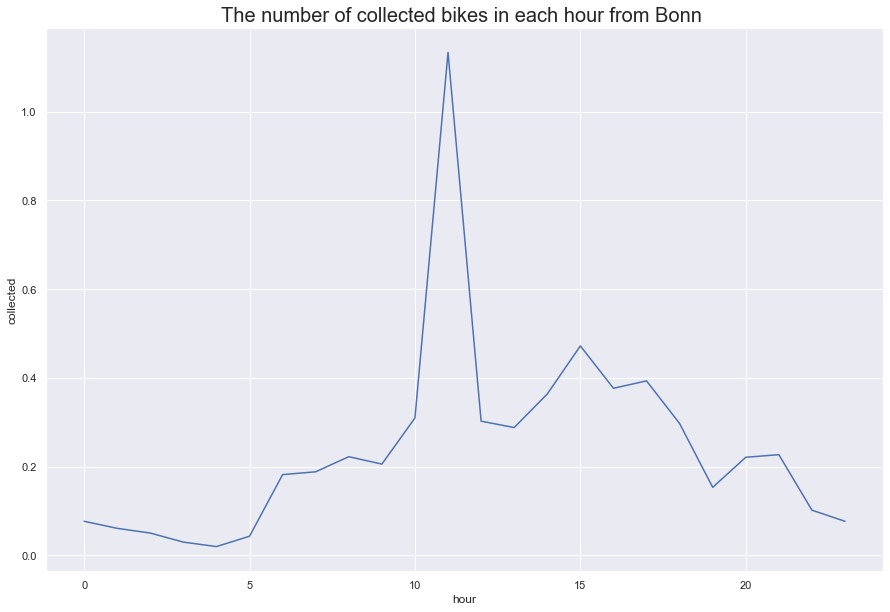

In [67]:
plt.figure(figsize=(15, 10))
sns.set_theme(style="darkgrid")
g = sns.lineplot(data = agg_hour,x ='hour',y = 'collected',palette="tab10")
g.axes.set_title(label = f"The number of collected bikes in each hour from Bonn ",
fontsize = 20)
plt.show()

# City Las Palmas de Gran Canaria
- the analysis was performed in the city of Las Palmas de Gran Canaria
- there is a pick around 11 and smaller picks around 13,17.
- since the city is a tourist one and the data were collected throughout the holiday season we can assume 
    that tourists are the main users.
- the peaks might appear in the morning when they start sightseeing, before and after lunch
- the peaks are in the similar hours as they are in the historic data, which indicates that the trends do not differ very much throughout the year

In [70]:
cityname = 'Las Palmas de Gran Canaria'
city_uid = 408

In [71]:
agg_hour = return_data_for_city(cityname,city_uid)

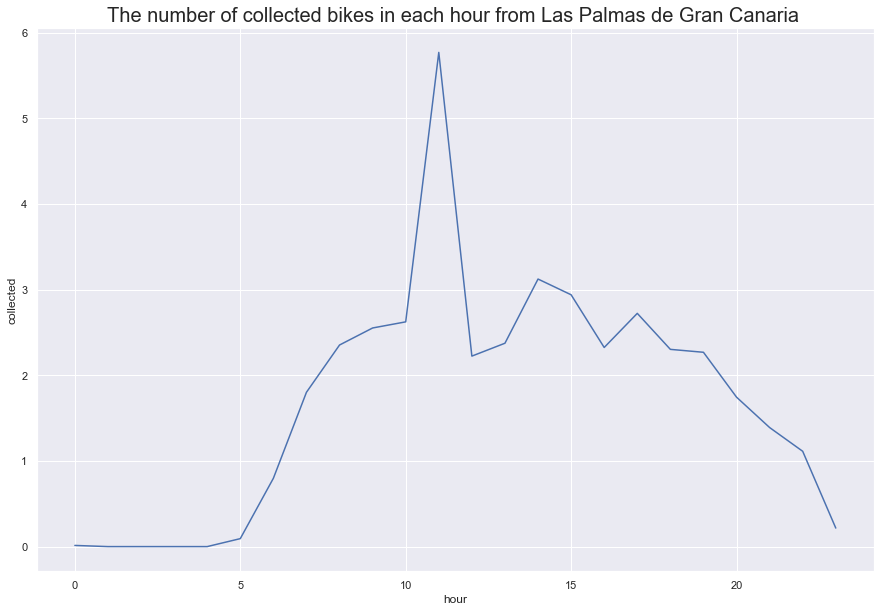

In [72]:
plt.figure(figsize=(15, 10))
sns.set_theme(style="darkgrid")
g = sns.lineplot(data = agg_hour,x ='hour',y = 'collected',palette="tab10")
g.axes.set_title(label = f"The number of collected bikes in each hour from {cityname} ",
fontsize = 20)
plt.show()